In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [58]:
freq_0 = 4.9e9
amp_0 = 0.05952946266816971
beta_0 = -0.050505050505050386

freq_1 = 5.5e9
amp_1 = 0.050331228595673023
beta_1 = -0.22448979591836737

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from qiskit import pulse
from qiskit_dynamics import Solver, DynamicsBackend 
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate, HGate
from qiskit.circuit import Parameter, Gate
from qiskit.providers.backend import QubitProperties
from qiskit.transpiler import InstructionProperties
from qiskit.providers.models import PulseDefaults


class TwoQubitPulseSimulator():
    def __init__(
        self,
        qubit_frequency_0 = 4.9e9,
        qubit_frequency_1 = 5.5e9,
        anharmonicity_0 = -0.4e9,
        anharmonicity_1 = -0.3e9,
        drive_strength_0 = 0.22e9,
        drive_strength_1 = 0.26e9,
    ):
        dim = 2

        self.v0 = qubit_frequency_0
        self.anharmon_0 = anharmonicity_0
        self.r0 = drive_strength_0
        
        self.v1 = qubit_frequency_1
        self.anharmon_1 = anharmonicity_1
        self.r1 = drive_strength_1
        
        self.J = 2.7e6
        
        a = np.diag(np.sqrt(np.arange(1, dim)), 1)
        adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
        N = np.diag(np.arange(dim))
        
        ident = np.eye(dim, dtype=complex)
        full_ident = np.eye(dim**2, dtype=complex)
        
        N0 = np.kron(ident, N)
        N1 = np.kron(N, ident)
        
        a0 = np.kron(ident, a)
        a1 = np.kron(a, ident)
        
        a0dag = np.kron(ident, adag)
        a1dag = np.kron(adag, ident)
        
        
        static_ham0 = 2 * np.pi * self.v0 * N0 + np.pi * self.anharmon_0 * N0 * (N0 - full_ident)
        static_ham1 = 2 * np.pi * self.v1 * N1 + np.pi * self.anharmon_1 * N1 * (N1 - full_ident)
        
        static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * self.J * ((a0 + a0dag) @ (a1 + a1dag))
        
        drive_op0 = 2 * np.pi * self.r0 * (a0 + a0dag)
        drive_op1 = 2 * np.pi * self.r1 * (a1 + a1dag)

        # build solver
        dt = 1/4.5e9
        
        self.solver = Solver(
            static_hamiltonian=static_ham_full,
            hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
            # rotating_frame=static_ham_full,
            hamiltonian_channels=["d0", "d1", "u0", "u1"],
            channel_carrier_freqs={"d0": self.v0, "d1": self.v1, "u0": self.v1, "u1": self.v0},
            dt=dt,
            array_library="jax",
        )

        # Consistent solver option to use throughout notebook
        solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}
        
        self.backend = DynamicsBackend(
            solver=self.solver,
            subsystem_dims=[dim, dim], # for computing measurement data
            solver_options=solver_options, # to be used every time run is called
            max_outcome_level=dim,
        )

        # self.backend.set_options(
        #     defaults = PulseDefaults.from_dict(
        #         {
        #             "qubit_freq_est": [self.v0, self.v1],
        #             "meas_freq_est": [0, 0],
        #             "buffer": 0,
        #             "pulse_library": [],
        #             "cmd_def":[]
        #         }
        #     )
        # )

        self.target = self.backend.target

        # qubit properties
        self.target.qubit_properties = [QubitProperties(frequency=self.v0), QubitProperties(frequency=self.v1)]
        
        #####################################################################################
        ##### add instructions for qutrits #####

        x01_gate = Gate('x01', 1, [])
        
        with pulse.build() as x01_0:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(0))
        
        with pulse.build() as x01_1:
            pulse.Play(pulse.Gaussian(320, 0.5, 80), pulse.DriveChannel(1))

        self.target.add_instruction(
            x01_gate,
            {
                (0,): InstructionProperties(calibration=x01_0), 
                (1,): InstructionProperties(calibration=x01_1)
            }
        )
        
        # self.target.add_instruction(XGate(), properties={(0,): None, (1,): None})
        # self.target.add_instruction(SXGate(), properties={(0,): None, (1,): None})
        
        self.target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})
        
        #### Add RZ instruction as phase shift for drag cal  #####
        phi = Parameter("phi")
        with pulse.build() as rz0:
            pulse.shift_phase(phi, pulse.DriveChannel(0))
            pulse.shift_phase(phi, pulse.ControlChannel(1))
        
        with pulse.build() as rz1:
            pulse.shift_phase(phi, pulse.DriveChannel(1))
            pulse.shift_phase(phi, pulse.ControlChannel(0))
        
        self.target.add_instruction(
            RZGate(phi),
            {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
        )

        ##################################################################################

        self.backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})

    def get_backend(self):
        return self.backend

    def get_solver(self):
        return self.solver

    def get_target(self):
        return self.target

/tmp/ipykernel_7350/1615242635.py:8: DeprecationWarning: qiskit.providers.models is deprecated since Qiskit 1.2 and will be removed in Qiskit 2.0. With the removal of Qobj, there is no need for these schema-conformant objects. If you still need to use them, it could be because you are using a BackendV1, which is also deprecated in favor of BackendV2.
  from qiskit.providers.models import PulseDefaults


In [4]:
sim = TwoQubitPulseSimulator()
target = sim.get_target()
backend = sim.get_backend()

In [5]:
import numpy as np

from qiskit import *

import matplotlib.pyplot as plt
from qiskit_experiments.curve_analysis.fit_function import *
from scipy.optimize import *

## Defining Additionally required functions

In [6]:
# Defining shifted pulse for 0-1 transition
def get_shifted_x01_pulse(freq, amp, drive, achan, memslot):
    with pulse.build(name="x01") as x01_pulse:
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Gaussian(320, amp, 80, limit_amplitude=False), drive)
        pulse.delay(320, achan)
        pulse.acquire(1, achan, memslot)
    return x01_pulse


# Defining shifted pulse for 0-2 transition
def get_shifted_x02_pulse(freq, ef_freq, amp, ef_amp, beta, drive, achan, memslot):
    with pulse.build(name="x") as x02_pulse:
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Drag(320, amp, 80, beta, limit_amplitude=False), drive)
        pulse.set_frequency(ef_freq, drive)
        pulse.play(pulse.Gaussian(320, ef_amp, 80, limit_amplitude=False), drive)
        pulse.delay(640, achan)
        pulse.acquire(1, achan, memslot)
    return x02_pulse

### Defining Drive Channels, Acquire Channels and Memory Slots for Individual Qutrit Spectroscopy

In [7]:
dchan0 = pulse.DriveChannel(0)
dchan1 = pulse.DriveChannel(1)

uchan0 = pulse.ControlChannel(0)
uchan1 = pulse.ControlChannel(1)

achan0 = pulse.AcquireChannel(0)
achan1 = pulse.AcquireChannel(1)

memslot = pulse.MemorySlot(0)

## Identifying optimal frequency for $|0\rangle \xrightarrow{} |1\rangle$ transition for Qubit 0

In [17]:
min_freq = 4.8e9
max_freq = 5.0e9
steps = 100

freq_results_array = []

for freq in np.linspace(min_freq, max_freq, steps):
    freq_test_pulse = get_shifted_x01_pulse(freq, 0.05, dchan0, achan0, memslot)
    
    result = backend.run(freq_test_pulse)
    freq_results_array.append(result)

/tmp/ipykernel_11142/1800813769.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_11142/1800813769.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_11142/1800813769.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

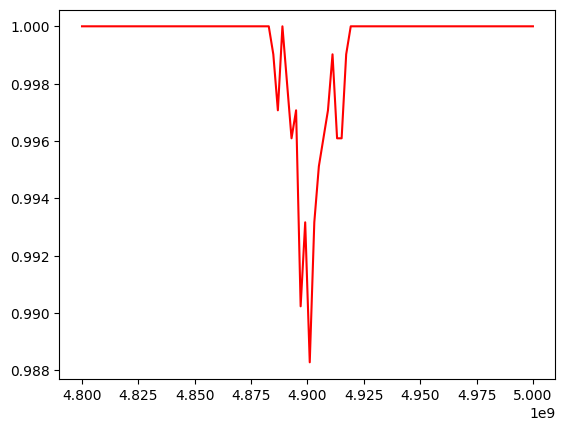

In [18]:
freq_prob_array_0 = [[], []]
for res in freq_results_array:
    for i in range(2):
        if str(i) in res.result().get_counts():
            count = res.result().get_counts()[str(i)]
        else:
            count = 0
        freq_prob_array_0[i].append(count/1024.)

freq_list = np.linspace(min_freq, max_freq, steps)
plt.plot(freq_list, freq_prob_array_0[0], color='r')

In [22]:
sqrt_lorentzian

<function qiskit_experiments.curve_analysis.fit_function.sqrt_lorentzian(x: numpy.ndarray, amp: float = 1.0, kappa: float = 1.0, x0: float = 0.0, baseline: float = 0.0) -> numpy.ndarray>

In [29]:
opt_params_freq_0, _ = curve_fit(sqrt_lorentzian, freq_list, freq_prob_array_0[0], bounds=([-1, -np.inf, freq_list[0], 0], [1, freq_list[-1], 4.9e9+1, 2]))

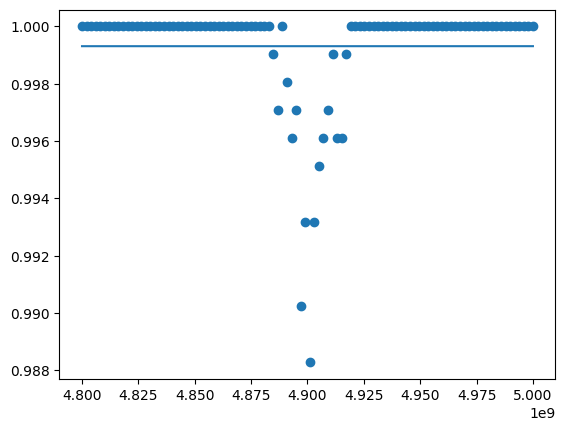

In [30]:
plt.scatter(freq_list, freq_prob_array_0[0])
plt.plot(freq_list, sqrt_lorentzian(freq_list, *opt_params_freq_0))

In [11]:
freq_0 = opt_params_freq_0[2]
print(freq_0)

4999160046.035381


In [8]:
# Overriding and setting the frequency of the transition to the actual value
freq_0 = 4.9e9

## Identifying optimal amplitude for $|0\rangle \xrightarrow{} |1\rangle$ transition for Qubit 0

In [11]:
min_amp = 0
max_amp = 0.2
steps = 100

amp_results_array = []

for amp in np.linspace(min_amp, max_amp, steps):
    amp_test_pulse = get_shifted_x01_pulse(freq_0, amp, dchan0, achan0, memslot)
    
    amp_job = backend.run(amp_test_pulse, meas_level=2, max_outcome_level=2)
    amp_results_array.append(amp_job)

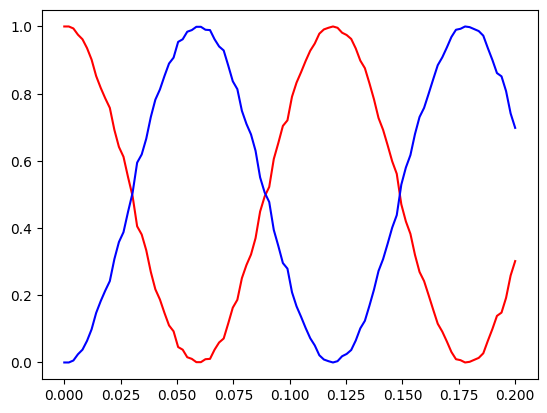

In [12]:
amp_prob_array_0 = [[], []]
for res in amp_results_array:
    for i in range(2):
        if str(i) in res.result().get_counts():
            count = res.result().get_counts()[str(i)]
        else:
            count = 0
        amp_prob_array_0[i].append(count/1024.)

amp_list = np.linspace(min_amp, max_amp, steps)
plt.plot(amp_list, amp_prob_array_0[0], color='r')
plt.plot(amp_list, amp_prob_array_0[1], color='b')

In [36]:
cos

<function qiskit_experiments.curve_analysis.fit_function.cos(x: numpy.ndarray, amp: float = 1.0, freq: float = 0.15915494309189535, phase: float = 0.0, baseline: float = 0.0) -> numpy.ndarray>

In [20]:
opt_params_amp_0, _ = curve_fit(cos, amp_list, amp_prob_array_0[0], bounds=([-2, 0, -2*np.pi, 0], [2, 25, np.pi, 1]))

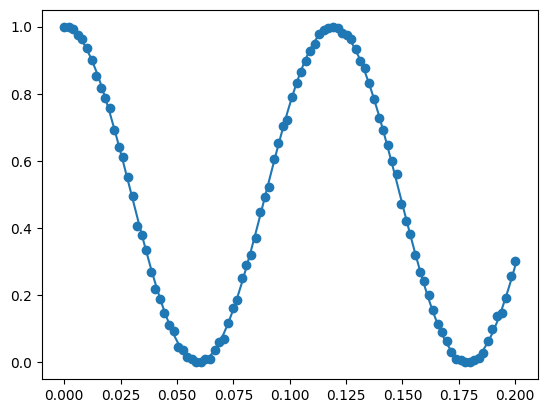

In [21]:
plt.scatter(amp_list, amp_prob_array_0[0])
plt.plot(amp_list, cos(amp_list, *opt_params_amp_0))

In [22]:
amp_0 = 1/(2*opt_params_amp_0[1])
print(amp_0)

0.05952946266816971


In [23]:
# Setting the 0->1 transition amplitude for qubit 0
amp_0 = 0.05952946266816971

### Trying DRAG-Calibration for 0->1 pulse in Qubit 0

In [24]:
# Defining shifted drag pulse for 0-1 transition
def get_shifted_x01_drag_pulse(freq, amp, beta, drive, achan, memslot, num_reps):
    with pulse.build(name="x01") as x01_pulse:
        pulse.set_frequency(freq, drive)
        for i in range(num_reps):
            pulse.play(pulse.Drag(320, amp, 80, beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
            pulse.play(pulse.Drag(320, amp, 80, beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
        pulse.delay((640*num_reps), achan)
        pulse.acquire(1, achan, memslot)
    return x01_pulse

In [26]:
min_beta = -1
max_beta = 1
steps = 100

drag_results_array = [[], [], []]
n_reps_list = [3,5,7]

for i, nreps in enumerate(n_reps_list):
    for beta in np.linspace(min_beta, max_beta, steps):
        drag_test_pulse = get_shifted_x01_drag_pulse(freq_0, amp_0, beta, dchan0, achan0, memslot, nreps)

        drag_job = backend.run(drag_test_pulse, meas_level=2, max_outcome_level=1)
        drag_results_array[i].append(drag_job)

In [27]:
prob_list = [[], [], []]
for i in range(3):
    for res in drag_results_array[i]:
        if '1' in res.result().get_counts():
            count = res.result().get_counts()['1']
        else:
            count = 0
        prob_list[i].append(count/1024.)

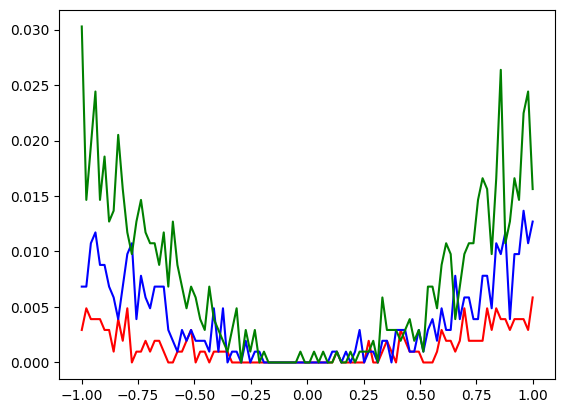

In [28]:
beta_list = np.linspace(min_beta, max_beta, steps)
plt.plot(beta_list, prob_list[0], color='r')
plt.plot(beta_list, prob_list[1], color='b')
plt.plot(beta_list, prob_list[2], color='g')

In [31]:
opt_params_0, _ = curve_fit(cos, beta_list, prob_list[0], bounds=([-1, -0.5, -np.inf, 0], [1, 0.5, np.inf, 1]))

In [33]:
opt_params_1, _ = curve_fit(cos, beta_list, prob_list[1], bounds=([-1, -1, -np.inf, 0], [1, 1, np.inf, 1]))

In [34]:
opt_params_2, _ = curve_fit(cos, beta_list, prob_list[2], bounds=([-2, -0.5, -np.inf, 0], [2, 0.5, np.inf, 1]))

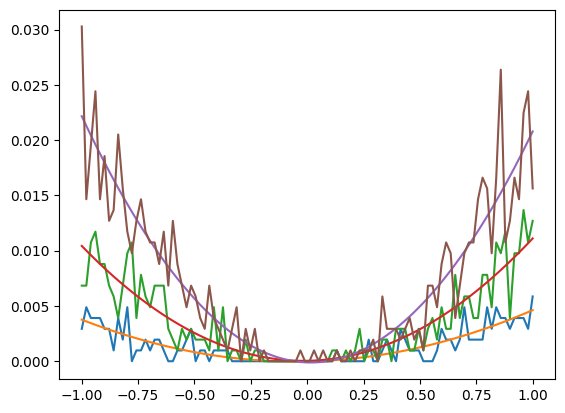

In [35]:
plt.plot(beta_list, prob_list[0])
plt.plot(beta_list, cos(beta_list, *opt_params_0))

plt.plot(beta_list, prob_list[1])
plt.plot(beta_list, cos(beta_list, *opt_params_1))

plt.plot(beta_list, cos(beta_list, *opt_params_2))
plt.plot(beta_list, prob_list[2])

In [20]:
print(opt_params_0)
print(opt_params_1)
print(opt_params_2)

[ 0.99999971 -0.01406047  3.03242913  0.99977249]
[ 0.27904225 -0.04506452  2.79203074  0.27853176]
[ 0.34463526 -0.05734711  2.69260799  0.34329554]


In [36]:
opt_y_0 = cos(beta_list, *opt_params_0)
opt_y_1 = cos(beta_list, *opt_params_1)
opt_y_2 = cos(beta_list, *opt_params_2)

opt_beta_list = [
    beta_list[np.where(opt_y_0 == min(opt_y_0))][0],
    beta_list[np.where(opt_y_1 == min(opt_y_1))][0],
    beta_list[np.where(opt_y_2 == min(opt_y_2))][0]
]

beta_0 = max(set(list(opt_beta_list)), key=opt_beta_list.count)
print(beta_0)

-0.050505050505050386


In [37]:
beta_0 = -0.050505050505050386

------------------

## Identifying optimal frequency for $|0\rangle \xrightarrow{} |1\rangle$ transition for Qubit 1

In [68]:
min_freq = 5.4e9
max_freq = 5.6e9
steps = 50

freq_results_array = []

for freq in np.linspace(min_freq, max_freq, steps):
    freq_test_pulse = get_shifted_x01_pulse(freq, 0.05, dchan1, achan1, memslot) 
    
    result = backend.run(freq_test_pulse, meas_level=2, max_outcome_level=2)
    freq_results_array.append(result)

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

/tmp/ipykernel_15735/2235599673.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x01") as x01_pulse:
/tmp/ipykernel_15735/2235599673.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2235599673.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

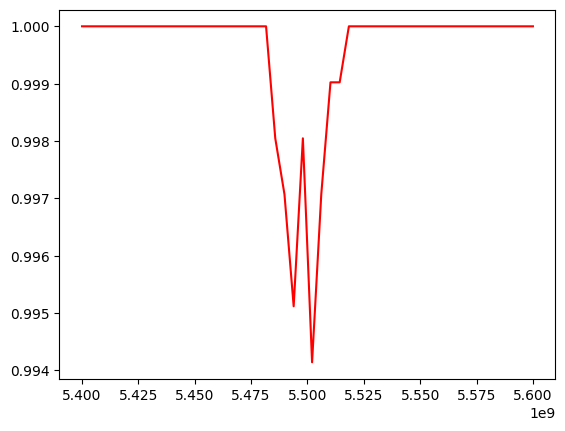

In [69]:
freq_prob_array_1 = [[], []]
for res in freq_results_array:
    for i in range(2):
        if str(i) in res.result().get_counts():
            count = res.result().get_counts()[str(i)]
        else:
            count = 0
        freq_prob_array_1[i].append(count/1024.)

freq_list = np.linspace(min_freq, max_freq, steps)
plt.plot(freq_list, freq_prob_array_1[0], color='r')

In [38]:
# Setting 0->1 transition frequency of Qubit 1

freq_1 = 5.5e9

## Identifying optimal amplitude for $|0\rangle \xrightarrow{} |1\rangle$ transition for Qubit 1

In [39]:
min_amp = 0
max_amp = 0.2
steps = 100

amp_list_1 = np.linspace(min_amp, max_amp, steps)

amp_results_array = []

for amp in amp_list_1:
    amp_test_pulse = get_shifted_x01_pulse(freq_1, amp, dchan1, achan1, memslot)
    
    amp_job = backend.run(amp_test_pulse, meas_level=2, max_outcome_level=1)
    amp_results_array.append(amp_job)

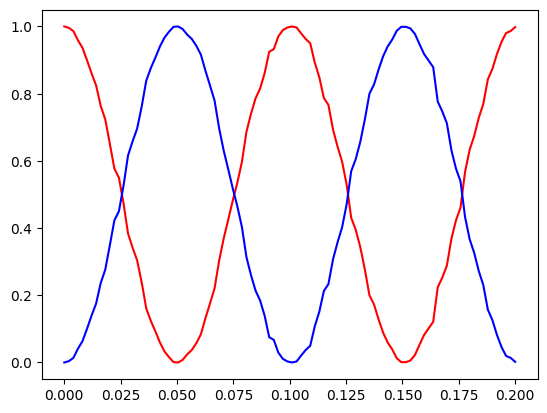

In [40]:
amp_prob_1 = [[], []]

for res in amp_results_array:
    for i in range(2):
        if str(i) in res.result().get_counts():
            count = res.result().get_counts()[str(i)]
        else:
            count = 0
        amp_prob_1[i].append(count/1024.)

amp_list_1 = np.linspace(min_amp, max_amp, steps)
plt.plot(amp_list_1, amp_prob_1[0], color='r')
plt.plot(amp_list_1, amp_prob_1[1], color='b')

In [75]:
cos

<function qiskit_experiments.curve_analysis.fit_function.cos(x: numpy.ndarray, amp: float = 1.0, freq: float = 0.15915494309189535, phase: float = 0.0, baseline: float = 0.0) -> numpy.ndarray>

In [43]:
opt_params_amp_1, _ = curve_fit(cos, amp_list_1, amp_prob_1[0], bounds=([-1, 0, -2*np.pi, -1], [1, 20, 2*np.pi, 1]))

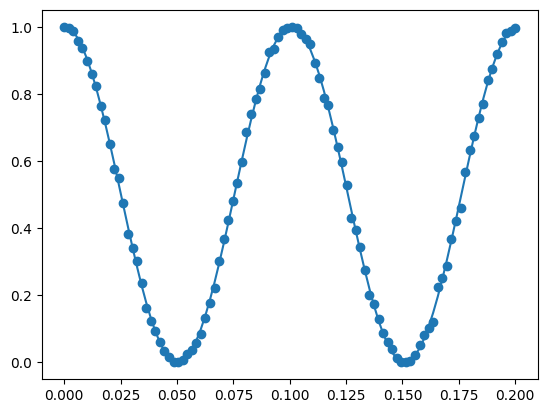

In [44]:
plt.scatter(amp_list_1, amp_prob_1[0])
plt.plot(amp_list_1, cos(amp_list_1, *opt_params_amp_1))

In [45]:
amp_1 = 1/(2*opt_params_amp_1[1])
print(amp_1)

0.050331228595673023


In [46]:
# Setting the 0->1 transition amplitude for qubit 1
amp_1 = 0.050331228595673023

### Trying DRAG-Calibration for 0->1 pulse in Qubit 1

In [47]:
# Defining shifted drag pulse for 0-1 transition
def get_shifted_x01_drag_pulse(freq, amp, beta, drive, achan, memslot, num_reps):
    with pulse.build(name="x01") as x01_pulse:
        pulse.set_frequency(freq, drive)
        for i in range(num_reps):
            pulse.play(pulse.Drag(320, amp, 80, beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
            pulse.play(pulse.Drag(320, amp, 80, beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
        pulse.delay((640*num_reps), achan)
        pulse.acquire(1, achan, memslot)
    return x01_pulse

In [48]:
min_beta = -1
max_beta = 1
steps = 50

drag_results_array = [[], [], []]
n_reps_list = [3,5,7]

for i, nreps in enumerate(n_reps_list):
    for beta in np.linspace(min_beta, max_beta, steps):
        drag_test_pulse = get_shifted_x01_drag_pulse(freq_1, amp_1, beta, dchan1, achan1, memslot, nreps)

        drag_job = backend.run(drag_test_pulse, meas_level=2, max_outcome_level=1)
        drag_results_array[i].append(drag_job)

In [49]:
prob_list = [[], [], []]
for i in range(3):
    for res in drag_results_array[i]:
        if '1' in res.result().get_counts():
            count = res.result().get_counts()['1']
        else:
            count = 0
        prob_list[i].append(count/1024.)

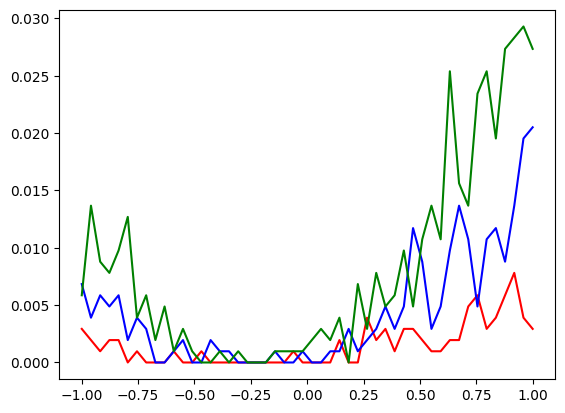

In [50]:
beta_list = np.linspace(min_beta, max_beta, steps)
plt.plot(beta_list, prob_list[0], color='r')
plt.plot(beta_list, prob_list[1], color='b')
plt.plot(beta_list, prob_list[2], color='g')

In [51]:
opt_params_0, _ = curve_fit(cos, beta_list, prob_list[0], bounds=([-1, -0.5, -np.inf, 0], [1, 0.5, np.inf, 1]))

In [52]:
opt_params_1, _ = curve_fit(cos, beta_list, prob_list[1], bounds=([-1, -1, -np.inf, 0], [1, 1, np.inf, 1]))

In [53]:
opt_params_2, _ = curve_fit(cos, beta_list, prob_list[2], bounds=([-2, -0.5, -np.inf, 0], [2, 0.5, np.inf, 1]))

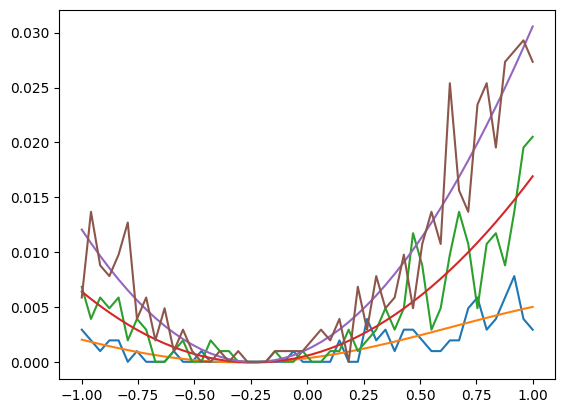

In [54]:
plt.plot(beta_list, prob_list[0])
plt.plot(beta_list, cos(beta_list, *opt_params_0))

plt.plot(beta_list, prob_list[1])
plt.plot(beta_list, cos(beta_list, *opt_params_1))

plt.plot(beta_list, cos(beta_list, *opt_params_2))
plt.plot(beta_list, prob_list[2])

In [95]:
print(opt_params_0)
print(opt_params_1)
print(opt_params_2)

[0.02693055 0.08881632 4.14061624 0.02722826]
[0.99999966 0.02372737 3.42731442 1.00047086]
[0.31433279 0.06011798 3.86020556 0.31424313]


In [55]:
opt_y_0 = cos(beta_list, *opt_params_0)
opt_y_1 = cos(beta_list, *opt_params_1)
opt_y_2 = cos(beta_list, *opt_params_2)

opt_beta_list = [
    beta_list[np.where(opt_y_0 == min(opt_y_0))][0],
    beta_list[np.where(opt_y_1 == min(opt_y_1))][0],
    beta_list[np.where(opt_y_2 == min(opt_y_2))][0]
]

beta_1 = max(set(list(opt_beta_list)), key=opt_beta_list.count)
print(beta_1)

-0.22448979591836737


In [56]:
beta_1 = -0.22448979591836737

### Trying DRAG-Calibration for 0->1 pulse in Qubit 1

In [133]:
freq_0 = 4.9e9
amp_0 = 0.05952946266816971
beta_0 = -0.050505050505050386

freq_1 = 5.5e9
amp_1 = 0.050331228595673023
beta_1 = -0.22448979591836737

In [119]:
# Defining shifted drag pulse for 0-1 transition
def get_shifted_x02_drag_pulse(freq, ef_freq, amp, ef_amp, beta, ef_beta, drive, achan, memslot, num_reps):
    with pulse.build(name="x02_drag") as x02_drag_pulse:
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Drag(320, amp, 80, beta, limit_amplitude=False), drive)
        pulse.set_frequency(ef_freq, drive)
        for i in range(num_reps):
            pulse.play(pulse.Drag(320, ef_amp, 80, ef_beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
            pulse.play(pulse.Drag(320, ef_amp, 80, ef_beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
        pulse.delay(640*(num_reps+1), achan)
        pulse.acquire(1, achan, memslot)
    return x02_drag_pulse

In [123]:
min_beta = -6
max_beta = -1
steps = 50

drag_results_array = [[], [], []]
n_reps_list = [3,5,7]

for i, nreps in enumerate(n_reps_list):
    print('nreps: ', nreps)
    for beta in np.linspace(min_beta, max_beta, steps):
        drag_test_pulse = get_shifted_x02_drag_pulse(freq_1, ef_freq_1, amp_1, ef_amp_1, beta_1, beta, dchan1, achan1, memslot, nreps)

        drag_job = backend.run(drag_test_pulse, meas_level=2, max_outcome_level=2)
        drag_results_array[i].append(drag_job)

nreps:  3


/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

nreps:  5


/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

nreps:  7


/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

/tmp/ipykernel_15735/2186300675.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="x02_drag") as x02_drag_pulse:
/tmp/ipykernel_15735/2186300675.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq, drive)
/tmp/ipykernel_15735/2186300675.py:5: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qi

In [124]:
prob_list = [[], [], []]
for i in range(3):
    for res in drag_results_array[i]:
        if '1' in res.result().get_counts():
            count = res.result().get_counts()['1']
        else:
            count = 0
        prob_list[i].append(count/1024.)

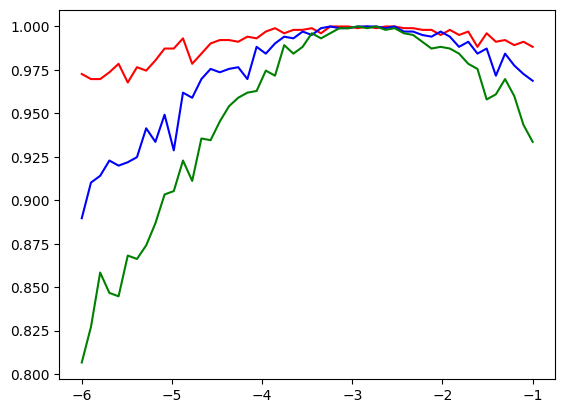

In [125]:
beta_list = np.linspace(min_beta, max_beta, steps)
plt.plot(beta_list, prob_list[0], color='r')
plt.plot(beta_list, prob_list[1], color='b')
plt.plot(beta_list, prob_list[2], color='g')

In [126]:
opt_params_0, _ = curve_fit(cos, beta_list, prob_list[0], bounds=([-1, -0.5, -np.inf, -np.inf], [1, 0.5, np.inf, np.inf]))

In [127]:
opt_params_1, _ = curve_fit(cos, beta_list, prob_list[1], bounds=([0, 0, -np.pi, 0], [1, 0.1, np.pi, 1]))

In [128]:
opt_params_2, _ = curve_fit(cos, beta_list, prob_list[2], bounds=([-2, -0.5, -np.inf, -np.inf], [2, 0.5, np.inf, np.inf]))

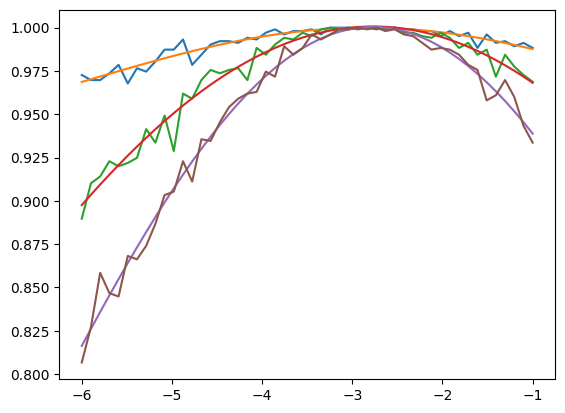

In [129]:
plt.plot(beta_list, prob_list[0])
plt.plot(beta_list, cos(beta_list, *opt_params_0))

plt.plot(beta_list, prob_list[1])
plt.plot(beta_list, cos(beta_list, *opt_params_1))

plt.plot(beta_list, cos(beta_list, *opt_params_2))
plt.plot(beta_list, prob_list[2])

In [130]:
print(opt_params_0)
print(opt_params_1)
print(opt_params_2)

[-0.02978028  0.0817457   4.60096508  0.97017946]
[0.27116118 0.04448883 0.77456874 0.72952639]
[-0.24388687  0.06527542  4.27880714  0.75656445]


In [131]:
opt_y_0 = cos(beta_list, *opt_params_0)
opt_y_1 = cos(beta_list, *opt_params_1)
opt_y_2 = cos(beta_list, *opt_params_2)

opt_beta_list = [
    beta_list[np.where(opt_y_0 == max(opt_y_0))][0],
    beta_list[np.where(opt_y_1 == max(opt_y_1))][0],
    beta_list[np.where(opt_y_2 == max(opt_y_2))][0]
]

beta_1 = max(set(list(opt_beta_list)), key=opt_beta_list.count)
print(beta_1)

-2.7346938775510203


In [132]:
ef_beta_1 = -2.7346938775510203

In [156]:
# print(freq_0, ef_freq_0, amp_0, ef_amp_0, beta_0, ef_beta_0)
print(freq_1, ef_freq_1, amp_1, ef_amp_1, beta_1)

5400000000.0 5106604115.060266 0.0595528836350621 0.043870938853229 -10.252525252525253


--------------------------------------------------------------------------------------

## Testing the obtained frequency and amplitudes

In [ ]:
x01_pulse_0 = get_shifted_x01_pulse(freq_0, amp_0, dchan0, achan0, memslot)

job01 = backend.run(x01_pulse_0, meas_level=2, max_outcome_level=2)
counts = job01.result().get_counts()
print(counts)

In [ ]:
x02_pulse_0 = get_shifted_x02_pulse(freq_0, ef_freq_0, amp_0, ef_amp_0, dchan0, achan0, memslot)

job02 = backend.run(x02_pulse_0, meas_level=2, max_outcome_level=2)
counts = job02.result().get_counts()
print(counts)

In [ ]:
x01_pulse_1 = get_shifted_x01_pulse(freq_1, amp_1, dchan1, achan1, memslot)

job01 = backend.run(x01_pulse_0, meas_level=2, max_outcome_level=2)
counts = job01.result().get_counts()
print(counts)

In [ ]:
x02_pulse_1 = get_shifted_x02_pulse(freq_1, ef_freq_1, amp_1, ef_amp_1, dchan1, achan1, memslot)

job02 = backend.run(x02_pulse_0, meas_level=2, max_outcome_level=2)
counts = job02.result().get_counts()
print(counts)

---------------------------

In [ ]:
amp_0

In [ ]:
def get_cr_pulse_0(amp):
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_0, dchan0)
        # pulse.set_frequency(freq_1, uchan0)
        pulse.play(pulse.Gaussian(320, amp_0/2, 80), dchan0)
        pulse.delay(320, uchan0)
        # pulse.play(pulse.GaussianSquare(320, amp_0, 80, 200), dchan)
        pulse.play(pulse.GaussianSquare(700, amp, 64, 640), uchan0)
        # pulse.delay(640, achan0)
        # pulse.delay(640, achan1)
        pulse.delay(1020, achan0)
        pulse.delay(1020, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

In [ ]:
dur = 600
print(cr_pulse.assign_parameters({'duration': dur}))

In [39]:
uchan0 = pulse.ControlChannel(0)
uchan1 = pulse.ControlChannel(1)

/tmp/ipykernel_1773/1151742000.py:1: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  uchan0 = pulse.ControlChannel(0)
/tmp/ipykernel_1773/1151742000.py:2: DeprecationWarning: The class ``qiskit.pulse.channels.Channel`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  uchan1 = pulse.ControlChannel(1)


In [40]:
min_duration = 100
max_duration = 1000
steps = 100

def get_cr_pulse():
    dur = Parameter('duration')
    tot_time = dur + 320
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_0, dchan0)
        pulse.play(pulse.Gaussian(320, 0, 80), dchan0)
        pulse.delay(320, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 1, 0.2*dur, 0.95*dur), uchan0)
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

cr_job_array = []
for dur in np.linspace(min_duration, max_duration, steps):
    cr_pulse = get_cr_pulse()
    
    cr_pulse.assign_parameters({'duration': int(dur)})
    cr_job = backend.run(cr_pulse, meas_level=2, max_outcome_level=2)
    cr_job_array.append(cr_job)

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1554996032.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1554996032.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1554996032.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

In [41]:
cr_0_prob = [[],[],[]]

counts = 0
for res in cr_job_array:
    for i in range(3):
        if '0'+str(i) in res.result().get_counts():
            counts = res.result().get_counts()['0'+str(i)]
        else:
            counts = 0
        cr_0_prob[i].append(counts/1024.)

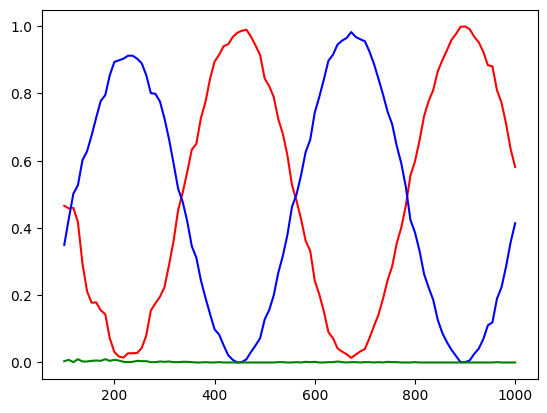

In [42]:
dur_list = np.linspace(min_duration, max_duration, steps)
plt.plot(dur_list, cr_0_prob[0], color='r')
plt.plot(dur_list, cr_0_prob[1], color='b')
plt.plot(dur_list, cr_0_prob[2], color='g')

In [43]:
min_duration = 100
max_duration = 1000
steps = 100

def get_cr_pulse():
    dur = Parameter('duration')
    tot_time = dur + 320
    with pulse.build(name="cr_0") as cr_pulse:
        pulse.set_frequency(freq_0, dchan0)
        pulse.play(pulse.Gaussian(320, amp_0, 80), dchan0)
        pulse.delay(320, uchan0)
        pulse.play(pulse.GaussianSquare(dur, 1, 0.2*dur, 0.95*dur), uchan0)
        pulse.delay(tot_time, achan0)
        pulse.delay(tot_time, achan1)
        pulse.acquire(1, achan0, pulse.MemorySlot(1))
        pulse.acquire(1, achan1, pulse.MemorySlot(0))
    return cr_pulse

cr_job_array = []
for dur in np.linspace(min_duration, max_duration, steps):
    cr_pulse = get_cr_pulse()
    
    cr_pulse.assign_parameters({'duration': int(dur)})
    cr_job = backend.run(cr_pulse, meas_level=2, max_outcome_level=2)
    cr_job_array.append(cr_job)

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

/tmp/ipykernel_1773/1136819212.py:8: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as cr_pulse:
/tmp/ipykernel_1773/1136819212.py:9: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_1773/1136819212.py:10: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dyna

In [47]:
cr_1_prob = [[],[],[]]

counts = 0
tot_counts = 0
for res in cr_job_array:
    for i in range(3):
        if '1'+str(i) in res.result().get_counts():
            counts = res.result().get_counts()['1'+str(i)]
        else:
            counts = 0
        cr_1_prob[i].append(counts)
    tot_counts = cr_1_prob[0][-1] + cr_1_prob[1][-1] + cr_1_prob[2][-1]
    for i in range(3):
        cr_1_prob[i][-1] = cr_1_prob[i][-1]/tot_counts


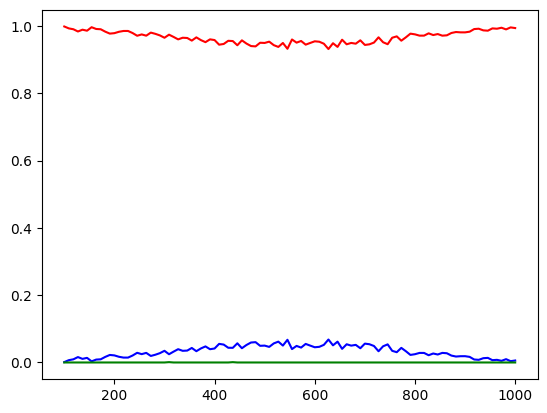

In [48]:
dur_list = np.linspace(min_duration, max_duration, steps)
plt.plot(dur_list, cr_1_prob[0], color='r')
plt.plot(dur_list, cr_1_prob[1], color='b')
plt.plot(dur_list, cr_1_prob[2], color='g')

### Checking the concurrence of the two qubit entangled state due to CR pulse

In [55]:
from qiskit.quantum_info import *
import scipy.linalg as la

In [45]:
freq_1 = 5.4e9

In [47]:
shifted_freq_0 = freq_0 - (sim.J/(freq_0-freq_1))
shifted_freq_1 = freq_1 + (sim.J/(freq_0-freq_1))
print('Shifted_freq_0 : ', shifted_freq_0)
print('Shifted_freq_1 : ', shifted_freq_1)

Shifted_freq_0 :  5000000000.05
Shifted_freq_1 :  5399999999.95


In [53]:
def qubit_concur(state):
    rho = DensityMatrix(state).data
    yy_mat = np.fliplr(np.diag([-1, 1, 1, -1]))
    sigma = rho.dot(yy_mat).dot(rho.conj()).dot(yy_mat)
    w = np.sort(np.real(la.eigvals(sigma)))
    w = np.sqrt(np.maximum(w, 0.0))
    
    return max(0.0, w[-1] - np.sum(w[0:-1]))

In [58]:
def get_equal_super_pulse(cr_amp, shifted_freq_0):
    dur = Parameter('dur')
    with pulse.build(name="cr_0") as super_pulse:
        pulse.set_frequency(freq_0, dchan0)
        
        # Applying a pulse to excite the state of the first qutrit to (|0> + |1>)/sqrt(2)
        pulse.play(pulse.Gaussian(320, (1/2)*amp_0, 80), dchan0)
        
        pulse.set_frequency(shifted_freq_0, uchan0)

        # Delaying the signal in the control channel by 640 units
        pulse.delay(320, uchan0)
        
        # Applying the cross resonance pulse on the control channel of first qubit
        pulse.play(pulse.GaussianSquare(dur, cr_amp, 64, dur-10, limit_amplitude=False), uchan0)
        
    return super_pulse

min_freq = freq_0-0.1
max_freq = freq_0+0.1
steps = 100

cr_amp = 1
dur = 2000

concur_list = []
for freq in np.linspace(min_freq, max_freq, steps):
    super_pulse = get_equal_super_pulse(cr_amp, freq)
    super_pulse.assign_parameters({'dur': int(dur)})
    y0 = Statevector([1,0,0,0])

    super_job = backend.solve(super_pulse, [0., (dur + 320)*dt], y0)

    # For using qubit_concurrence function
    #     t_state = Statevector(np.array([cr_job[0].y[-1].data[0], cr_job[0].y[-1].data[1], cr_job[0].y[-1].data[3], cr_job[0].y[-1].data[4]]))
    #     conc = qubit_concur(t_state)

    # For using qutrit_concurrence function
    t_state = super_job[0].y[-1]
#     print("------------------------")
    # print(np.round(Statevector(np.kron(np.array([1, 0, 0]), np.array([1/np.sqrt(3), np.sqrt(2)/np.sqrt(3), 0]))).data, 3))
    # print(np.round(t_state, 3))
#     print(np.round(t_state.probabilities(), 4))
    concur_list.append(qubit_concur(t_state))
    # print(eq_super_equiv(t_state))
#     print("------------------------")

/tmp/ipykernel_530/3852416978.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as super_pulse:
/tmp/ipykernel_530/3852416978.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_530/3852416978.py:7: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

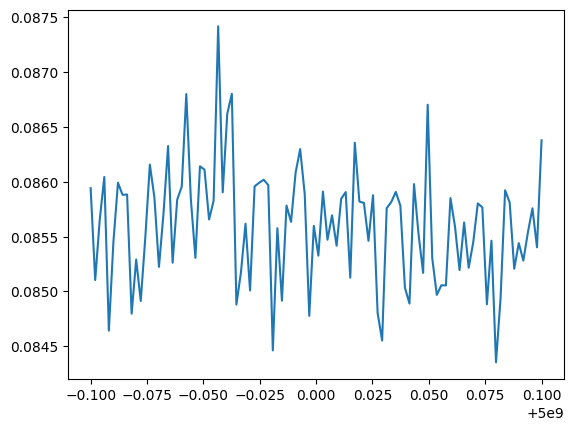

In [59]:
freq_list = np.linspace(min_freq, max_freq, steps)
plt.plot(freq_list, concur_list)

In [64]:
for freq in freq_list:
    print(freq)

4999999999.9
4999999999.9020195
4999999999.90404
4999999999.90606
4999999999.90808
4999999999.910101
4999999999.912121
4999999999.914141
4999999999.916162
4999999999.918181
4999999999.920201
4999999999.922222
4999999999.924242
4999999999.926262
4999999999.928283
4999999999.930303
4999999999.9323225
4999999999.934343
4999999999.936363
4999999999.938384
4999999999.940404
4999999999.942424
4999999999.944445
4999999999.946465
4999999999.948484
4999999999.950505
4999999999.952525
4999999999.954545
4999999999.956566
4999999999.958586
4999999999.960606
4999999999.962626
4999999999.964646
4999999999.966666
4999999999.968687
4999999999.970707
4999999999.972727
4999999999.974748
4999999999.976768
4999999999.978787
4999999999.980808
4999999999.982828
4999999999.984848
4999999999.986869
4999999999.988889
4999999999.990909
4999999999.992929
4999999999.994949
4999999999.996969
4999999999.99899
5000000000.00101
5000000000.003031
5000000000.005051
5000000000.007071
5000000000.009091
5000000000.011111


In [65]:
np.where(freq_list == 5000000000.00101)

(array([50]),)

In [66]:
concur_list[50]

np.float64(0.0853266534657041)

In [96]:
def get_equal_super_pulse(cr_amp):
    dur = Parameter('dur')
    with pulse.build(name="cr_0") as super_pulse:
        pulse.set_frequency(freq_0, dchan0)
        
        # Applying a pulse to excite the state of the first qutrit to (|0> + |1>)/sqrt(2)
        pulse.play(pulse.Gaussian(320, (1/2)*amp_0, 80), dchan0)

        # Delaying the signal in the control channel by 640 units
        pulse.delay(320, uchan0)
        
        # Applying the cross resonance pulse on the control channel of first qubit
        pulse.play(pulse.GaussianSquare(dur, cr_amp, 64, dur-10, limit_amplitude=False), uchan0)
        
    return super_pulse

cr_amp = 0.1
dur = 2000

min_amp = 0.2
max_amp = 0.3
steps = 100

amp_concur_list = []
for amp in np.linspace(min_amp, max_amp, steps):
    super_pulse = get_equal_super_pulse(amp)
    super_pulse.assign_parameters({'dur': int(dur)})
    y0 = Statevector([1,0,0,0])

    super_job = backend.solve(super_pulse, [0., (dur + 320)*dt], y0)
    t_state = super_job[0].y[-1]
    #     print("------------------------")
#     print(t_state.data)
    ref_state = np.array([1/np.sqrt(2),1j/np.sqrt(2),0,0])
#     print('Fid : ', np.absolute(ref_state.dot(t_state.data)))
#     print(t_state.probabilities())
#     print(qubit_concur(t_state))
    amp_concur_list.append(qubit_concur(t_state))
    # print(eq_super_equiv(t_state))
    #     print("------------------------")

/tmp/ipykernel_530/2902553606.py:3: DeprecationWarning: The function ``qiskit.pulse.builder.build()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  with pulse.build(name="cr_0") as super_pulse:
/tmp/ipykernel_530/2902553606.py:4: DeprecationWarning: The function ``qiskit.pulse.builder.set_frequency()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics
  pulse.set_frequency(freq_0, dchan0)
/tmp/ipykernel_530/2902553606.py:7: DeprecationWarning: The function ``qiskit.pulse.builder.play()`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynam

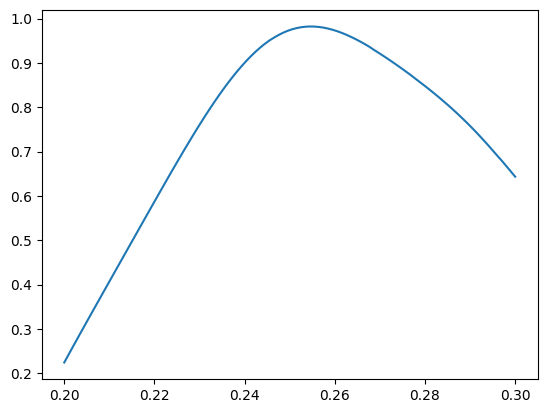

In [97]:
amp_list = np.linspace(min_amp, max_amp, steps)
plt.plot(amp_list, amp_concur_list)

In [100]:
max(amp_concur_list)

np.float64(0.9822904335433184)

In [98]:
amp_concur_list.index(max(amp_concur_list))

54

In [99]:
amp_list[amp_concur_list.index(max(amp_concur_list))]

np.float64(0.2545454545454545)